# **Inisisialisasi Konfigurasi Pelatihan**

In [1]:
class cfg:
    IMAGE_SIZE = 256
    # Data Augmentasi
    BRIGHTNESS = (0.64, 1.37)
    CONTRAST = (0.64, 1.37)
    # Pelatihan Model
    AUGMENTED = False
    DROPOUT = 0.5
    BATCH_SIZE = 8
    EPOCHS = 150
    LEARNING_RATE = 0.0001

# **Inisialisasi Library yang Digunakan**

In [2]:
# Library Machine Learning dan Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Library Pengolahan Data dan File
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

# Library Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Library Lain-Lain
import random
import os
import time
import json

# **Setting Environment Notebook**

In [3]:
# Mematikan Peringatan Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Mengatur seed
tf.random.set_seed(100)
np.random.seed(100)

In [4]:
# Mengaktifkan Presisi Campuran Float16
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# **Inisialisasi Data Direktori dan Membuat Dataframe**

In [5]:
# Direktori Data
data_directories = [
    '/kaggle/input/dataset-klasifikasi-v5/COVID19',
    '/kaggle/input/dataset-klasifikasi-v5/NORMAL',
    '/kaggle/input/dataset-klasifikasi-v5/PNEUMONIA',
    '/kaggle/input/dataset-klasifikasi-v5/TUBERCULOSIS',
]

all_paths = []
all_labels = []

# Melakukan iterasi melalui setiap direktori
for data_dir in data_directories:
    if not os.path.exists(data_dir):  # Skip jika direktori tidak ada
        print(f"Directory {data_dir} does not exist. Skipping.")
        continue
    
    # Mengambil semua file dalam direktori
    for image in os.listdir(data_dir):
        # Memastikan file adalah citra
        if image.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_paths.append(os.path.join(data_dir, image)) 
            # Menambahkan label dari nama folder
            label = os.path.basename(os.path.normpath(data_dir))
            all_labels.append(label)

# Mengacak Data
all_paths, all_labels = shuffle(all_paths, all_labels)

# Menampilkan sebagai DataFrame
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path': all_paths, 'label': all_labels})

print(df)

                                                                                  path  \
0                    /kaggle/input/dataset-klasifikasi-v5/COVID19/seg_COVID19(521).jpg   
1                    /kaggle/input/dataset-klasifikasi-v5/COVID19/seg_COVID19(123).jpg   
2      /kaggle/input/dataset-klasifikasi-v5/PNEUMONIA/seg_person658_bacteria_2550.jpeg   
3           /kaggle/input/dataset-klasifikasi-v5/TUBERCULOSIS/seg_Tuberculosis-366.png   
4            /kaggle/input/dataset-klasifikasi-v5/NORMAL/seg_NORMAL2-IM-0386-0001.jpeg   
...                                                                                ...   
4862  /kaggle/input/dataset-klasifikasi-v5/PNEUMONIA/seg_person1830_bacteria_4693.jpeg   
4863         /kaggle/input/dataset-klasifikasi-v5/NORMAL/seg_NORMAL2-IM-0450-0001.jpeg   
4864                  /kaggle/input/dataset-klasifikasi-v5/COVID19/seg_COVID19(71).jpg   
4865                 /kaggle/input/dataset-klasifikasi-v5/COVID19/seg_COVID19(512).jpg   
4866   /ka

# **Membuat Fungsi Augmentasi dan Membaca Citra**

In [6]:
# Fungsi Augmentasi
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    brightness_factor = random.uniform(cfg.BRIGHTNESS[0], cfg.BRIGHTNESS[1])
    contrast_factor = random.uniform(cfg.CONTRAST[0], cfg.CONTRAST[1])
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    return image   

In [7]:
# Fungsi Untuk Membuka dan Memproses Gambar
def open_images(paths, augment=True):
    images = []
    for path in paths:
        image = load_img(path, target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image / image.max()
        images.append(image)
    return np.array(images)

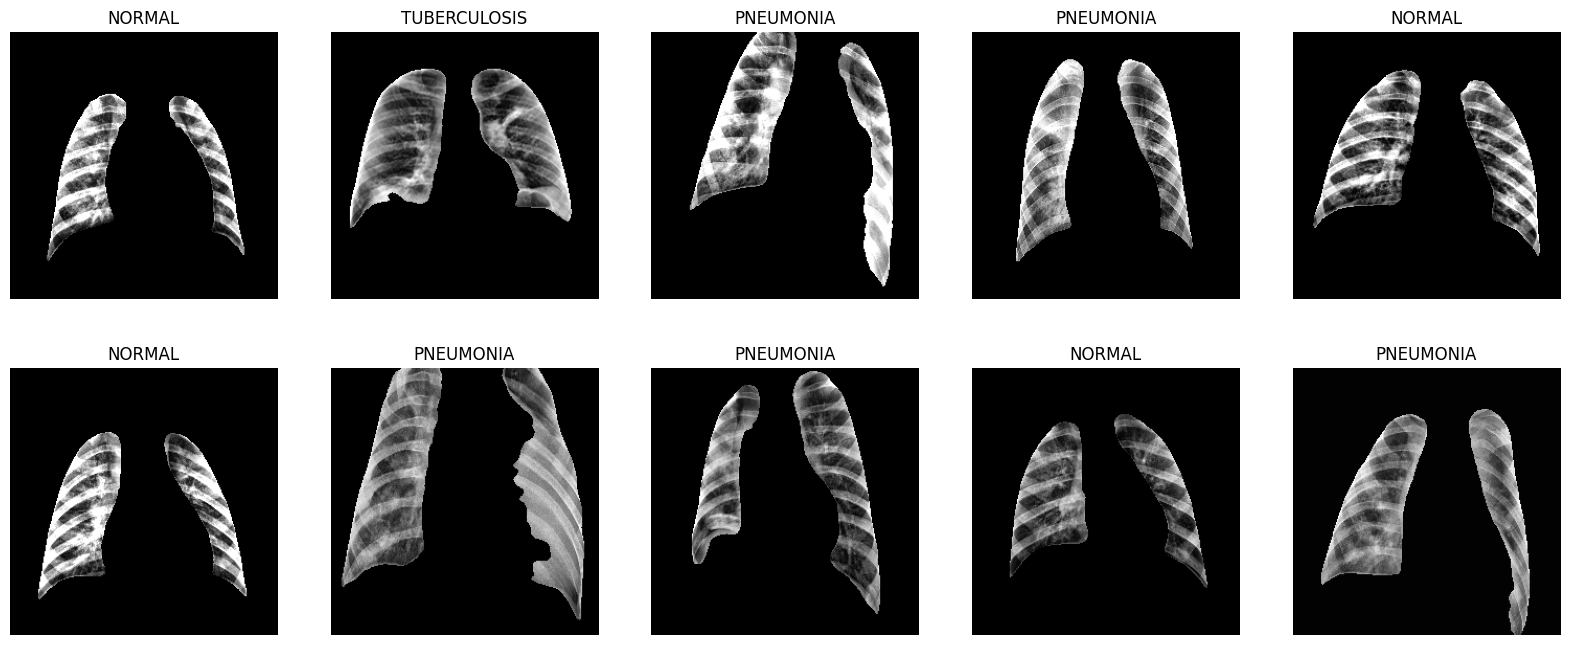

In [8]:
# Visualisasi Beberapa Citra dengan Augmentasi
k = random.randint(0, 5000)
image_paths = list(df.path[k:k + 10])
labels = list(df.label[k:k + 10])
images = open_images(image_paths, augment=True)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))
for i in range(0, 10):
    fig.add_subplot(2, 5, i + 1)
    plt .imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

# **Setting Label Encoder-Decoder**

In [9]:
# Daftar Label dan Pengkodeannya
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID19'}

# **Pembagian Data**

In [10]:
# Menentukan Persentase Pembagian Data
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Memastikan total persentase sesuai dengan 100%
assert train_split + val_split + test_split == 1.0, "Total split harus 1.0"

# Menghitung indeks pemisahan
train_end = int(train_split * len(df))
val_end = train_end + int(val_split * len(df))

# Melakukan pemisahan dataset
df_train = df[:train_end]
df_val = df[train_end:val_end]
df_test = df[val_end:]

print(f"Train set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")

Train set: 3893 samples
Validation set: 486 samples
Test set: 488 samples


# **Membuat Data Generator**

In [11]:
# Generator data untuk train, val, dan test
def data_generator(df, batch_size=cfg.BATCH_SIZE, augment=False, epochs=cfg.EPOCHS):
    for e in range(epochs):
        for x in range(0, len(df), batch_size):
            image_paths = df.path[x:x + batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x + batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

# Generator masing-masing set
train_data_generator = data_generator(df_train, batch_size=cfg.BATCH_SIZE, augment=cfg.AUGMENTED)
val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE)
test_data_generator = data_generator(df_test, batch_size=cfg.BATCH_SIZE)

train_steps = int(len(df_train) / cfg.BATCH_SIZE)
val_steps = int(len(df_val) / cfg.BATCH_SIZE)
test_steps = int(len(df_test) / cfg.BATCH_SIZE)

# **Visualisasi Pembagian Data**

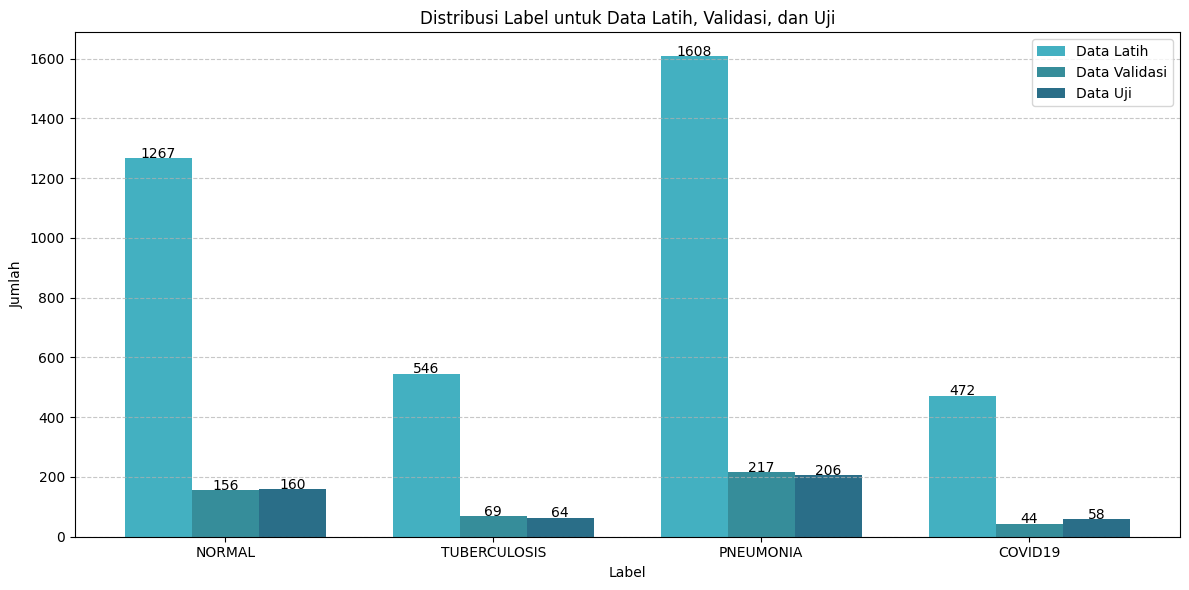

In [12]:
# Distribusi label pada setiap subset
train_counts = df_train['label'].value_counts()
val_counts = df_val['label'].value_counts()
test_counts = df_test['label'].value_counts()

# Visualisasi distribusi
plt.figure(figsize=(12, 6))

# Plot untuk setiap subset
x = np.arange(len(LABELS))
width = 0.25

plt.bar(x - width, train_counts.reindex(LABELS, fill_value=0), width, label='Data Latih', color='#43b0c1')
plt.bar(x, val_counts.reindex(LABELS, fill_value=0), width, label='Data Validasi', color='#368d9a')
plt.bar(x + width, test_counts.reindex(LABELS, fill_value=0), width, label='Data Uji', color='#2a6e88')

for i, v in enumerate(train_counts.reindex(LABELS, fill_value=0)):
    plt.text(i - width, v + 1, str(v), color='black', ha='center')

for i, v in enumerate(val_counts.reindex(LABELS, fill_value=0)):
    plt.text(i, v + 1, str(v), color='black', ha='center')

for i, v in enumerate(test_counts.reindex(LABELS, fill_value=0)):
    plt.text(i + width, v + 1, str(v), color='black', ha='center')

plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Label untuk Data Latih, Validasi, dan Uji')
plt.xticks(x, LABELS)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Membuat Model**

In [13]:
# Model CNN
# Input layer
input_layer = Input(shape=(256, 256, 3))

# Conv2D layers with MaxPooling2D and Dropout
x = Conv2D(16, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout layer
x = Dropout(cfg.DROPOUT)(x)

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,753,188 (10.50 MB)

 Trainable params: 2,753,188 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
'''
# MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Bekukan model dasar untuk mencegah perubahan saat pelatihan
base_model.trainable = False

# Buat model menggunakan Functional API
inputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dropout(0.3, name='dropout1')(x)
x = layers.Dense(256, activation='relu', name='dense1')(x)
outputs = layers.Dense(4, activation='softmax', name='final')(x)

# Buat model dengan nama 'MobileNetV2_classifier'
model = models.Model(inputs=inputs, outputs=outputs, name='MobileNetV2_classifier')

# Tampilkan ringkasan model
model.summary()
'''

"\n# MobileNetV2\nbase_model = tf.keras.applications.MobileNetV2(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),\n                                               include_top=False,\n                                               weights='imagenet')\n\n# Bekukan model dasar untuk mencegah perubahan saat pelatihan\nbase_model.trainable = False\n\n# Buat model menggunakan Functional API\ninputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))\nx = base_model(inputs, training=False) \nx = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)\nx = layers.Dropout(0.3, name='dropout1')(x)\nx = layers.Dense(256, activation='relu', name='dense1')(x)\noutputs = layers.Dense(4, activation='softmax', name='final')(x)\n\n# Buat model dengan nama 'MobileNetV2_classifier'\nmodel = models.Model(inputs=inputs, outputs=outputs, name='MobileNetV2_classifier')\n\n# Tampilkan ringkasan model\nmodel.summary()\n"

In [15]:
'''
# VGG19
base_model = tf.keras.applications.VGG19(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dropout(0.3, name='dropout1')(x)
x = layers.Dense(256, activation='relu', name='dense1')(x)
outputs = layers.Dense(4, activation='softmax', name='final')(x)

model_vgg19 = models.Model(inputs=inputs, outputs=outputs, name='VGG19_classifier')
model_vgg19.summary()
'''

"\n# VGG19\nbase_model = tf.keras.applications.VGG19(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),\n                                               include_top=False,\n                                               weights='imagenet')\nbase_model.trainable = False\n\ninputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))\nx = base_model(inputs, training=False) \nx = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)\nx = layers.Dropout(0.3, name='dropout1')(x)\nx = layers.Dense(256, activation='relu', name='dense1')(x)\noutputs = layers.Dense(4, activation='softmax', name='final')(x)\n\nmodel_vgg19 = models.Model(inputs=inputs, outputs=outputs, name='VGG19_classifier')\nmodel_vgg19.summary()\n"

In [16]:
'''
# Xception
base_model = tf.keras.applications.Xception(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),
                                                  include_top=False,
                                                  weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dropout(0.3, name='dropout1')(x)
x = layers.Dense(256, activation='relu', name='dense1')(x)
outputs = layers.Dense(4, activation='softmax', name='final')(x)

model_xception = models.Model(inputs=inputs, outputs=outputs, name='Xception_classifier')
model_xception.summary()
'''

"\n# Xception\nbase_model = tf.keras.applications.Xception(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),\n                                                  include_top=False,\n                                                  weights='imagenet')\nbase_model.trainable = False\n\ninputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))\nx = base_model(inputs, training=False) \nx = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)\nx = layers.Dropout(0.3, name='dropout1')(x)\nx = layers.Dense(256, activation='relu', name='dense1')(x)\noutputs = layers.Dense(4, activation='softmax', name='final')(x)\n\nmodel_xception = models.Model(inputs=inputs, outputs=outputs, name='Xception_classifier')\nmodel_xception.summary()\n"

In [17]:
'''
# DenseNet201
base_model = tf.keras.applications.DenseNet201(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),
                                                     include_top=False,
                                                     weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dropout(0.3, name='dropout1')(x)
x = layers.Dense(256, activation='relu', name='dense1')(x)
outputs = layers.Dense(4, activation='softmax', name='final')(x)

model_densenet201 = models.Model(inputs=inputs, outputs=outputs, name='DenseNet201_classifier')
model_densenet201.summary()
'''

"\n# DenseNet201\nbase_model = tf.keras.applications.DenseNet201(input_shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3),\n                                                     include_top=False,\n                                                     weights='imagenet')\nbase_model.trainable = False\n\ninputs = layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3))\nx = base_model(inputs, training=False) \nx = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)\nx = layers.Dropout(0.3, name='dropout1')(x)\nx = layers.Dense(256, activation='relu', name='dense1')(x)\noutputs = layers.Dense(4, activation='softmax', name='final')(x)\n\nmodel_densenet201 = models.Model(inputs=inputs, outputs=outputs, name='DenseNet201_classifier')\nmodel_densenet201.summary()\n"

# **Kompilasi Model**

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# **Mengatur Kelas Weight**

In [19]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{2: 0.4130490624197277,
 0: 0.32545594657076804,
 1: 0.14025173388132545,
 3: 0.12124325712817878}

# **Membuat Fungsi Callback yang Digunakan Selama Pelatihan**

In [20]:
# Callback untuk menyimpan history training ke file JSON
class SaveHistoryCallback(Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path

    def on_train_end(self, logs=None):
        with open(self.file_path, 'w') as f:
            json.dump(self.model.history.history, f)

# Callback untuk menghitung waktu pelatihan
class TrainingTimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"Total training time: {elapsed_time:.2f} seconds")

# Callback untuk memplot metrik
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_metrics = {k: logs[k] for k in logs if 'val_' in k}
        print(f"Epoch {epoch + 1}: Validation Metrics: {val_metrics}")


# Definisi callback yang disediakan Keras
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Definisi callback custom
history_callback = SaveHistoryCallback(file_path='training_history.json')
training_time_callback = TrainingTimeCallback()

# Gabungkan semua callback
callbacks_list = [
    early_stopping,
    reduce_lr,
    checkpoint,
    history_callback,
    training_time_callback,
    MetricsCallback()
]

# **Pelatihan Model**

In [21]:
history = model.fit(train_data_generator,
                    epochs=cfg.EPOCHS,
                    steps_per_epoch=train_steps,
                    validation_data=val_data_generator,
                    validation_steps=val_steps,
                    callbacks=callbacks_list)

Epoch 1/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6422 - loss: 0.8394
Epoch 1: val_loss improved from inf to 0.32561, saving model to best_model.keras
Epoch 1: Validation Metrics: {'val_accuracy': 0.8770833611488342, 'val_loss': 0.32560861110687256}
486/486 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.6424 - loss: 0.8389 - val_accuracy: 0.8771 - val_loss: 0.3256 - learning_rate: 1.0000e-04
Epoch 2/150
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8548 - loss: 0.3480
Epoch 2: val_loss improved from 0.32561 to 0.23171, saving model to best_model.keras
Epoch 2: Validation Metrics: {'val_accuracy': 0.8995816111564636, 'val_loss': 0.23171274363994598}
486/486 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8549 - loss: 0.3479 - val_accuracy: 0.8996 - val_loss: 0.2317 - learning_rate: 1.0000e-04
Epoch 3/150
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9029 - loss: 0.2585
Epoch 3: val_loss did not improve from 0.23171
Epoch 3: Validation Metrics: {'

# **Visualisasi Hasil Pelatihan**

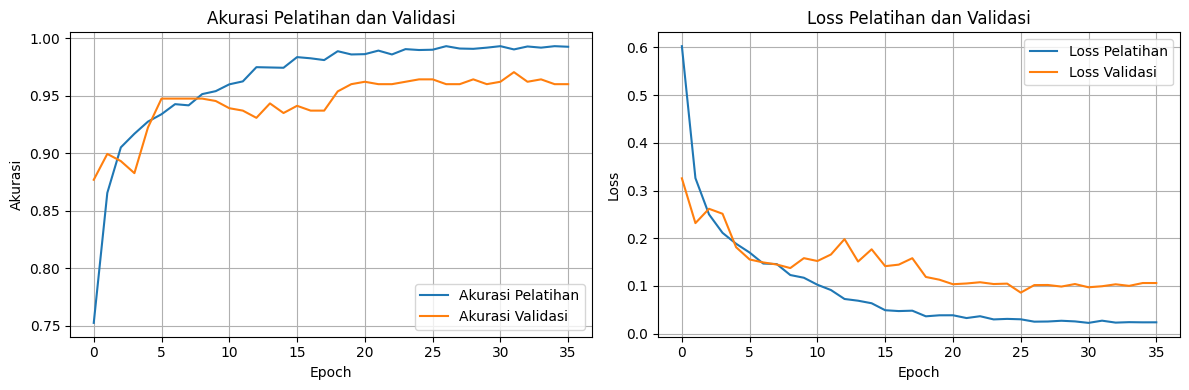

In [22]:
# Membuat plot dengan ukuran 12x4 inch
plt.figure(figsize=(12, 4))

# Tampilkan akurasi pelatihan dan validasi
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')  
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi') 
plt.xlabel('Epoch')  
plt.ylabel('Akurasi')  
plt.title('Akurasi Pelatihan dan Validasi')  
plt.legend()  
plt.grid()  

# Tampilkan loss pelatihan dan validasi
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Loss Pelatihan')  
plt.plot(history.history['val_loss'], label='Loss Validasi')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Loss Pelatihan dan Validasi')  
plt.legend()  
plt.grid()  

# Mengatur layout plot agar tidak overlap
plt.tight_layout()

# Menampilkan plot
plt.show()

# **Evaluasi Model dari Set Pengujian**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

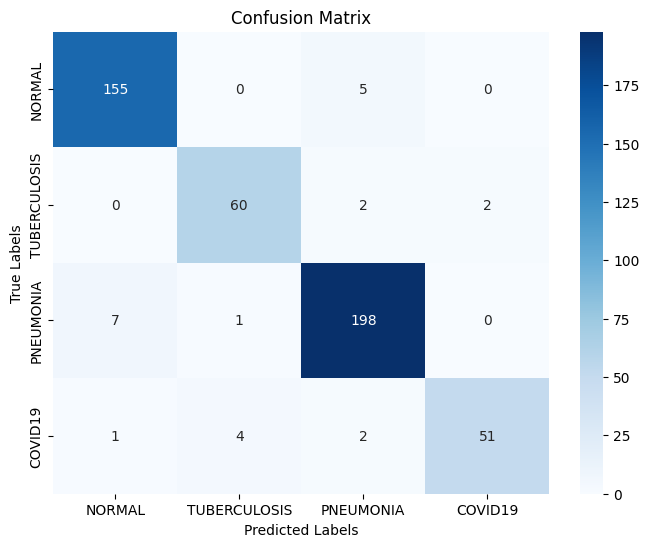

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Inisialisasi data untuk evaluasi
test_data_generator = data_generator(df_test, batch_size=cfg.BATCH_SIZE, augment=False, epochs=1)

# Inisialisasi prediksi dan label yang sesungguhnya
results = []  # Untuk menyimpan hasil evaluasi per sampel

# Inisialisasi nilai loss
loss = 0
count = 0

# Loop untuk mendapatkan prediksi dan label sesungguhnya
while True:
    try:
        x, y = next(test_data_generator)
        filenames = df_test.path[len(results):len(results) + len(y)]  # Ambil nama file batch
        
        # Prediksi probabilitas dan kelas
        preds = model.predict(x)
        pred_classes = np.argmax(preds, axis=-1)
        
        # Jika y adalah one-hot encoded
        if len(y.shape) > 1 and y.shape[-1] > 1:
            y = np.argmax(y, axis=-1)

        # Simpan hasil evaluasi
        for i, file_name in enumerate(filenames):
            result = {
                "filename": file_name,
                "true": int(y[i]),
                "predicted": int(pred_classes[i]),
                "probabilities": preds[i].tolist()
            }
            results.append(result)
        
        # Hitung nilai loss
        # Hitung nilai loss
        loss += model.evaluate(x, y, verbose=0)[0]
        count += 1
    except StopIteration:
        break

# Hitung nilai loss rata-rata
loss /= count
print(f'Test Loss: {loss:.4f}')

# Simpan hasil dalam CSV
df_results = pd.DataFrame(results)
df_results.to_csv("evaluation_results.csv", index=False)

# Tampilkan classification report
y_true = [r["true"] for r in results]
y_pred = [r["predicted"] for r in results]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=LABELS, digits=4))

# Visualisasi confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Nilai Akurasi Pengujian: {accuracy:.4%}")

Nilai Akurasi Pengujian: 95.0820%


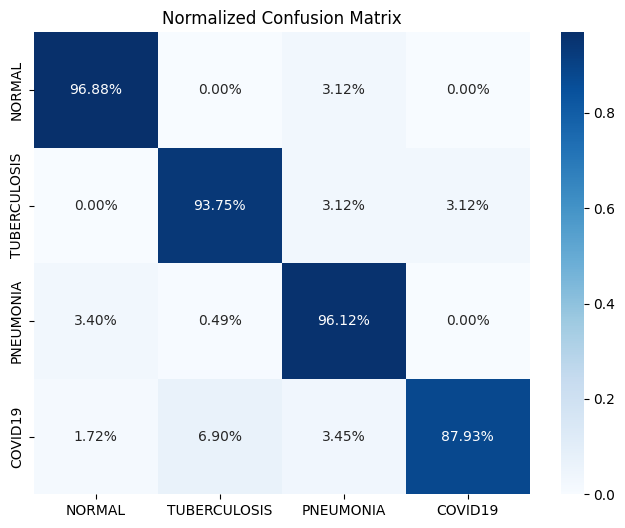

In [25]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title("Normalized Confusion Matrix")
plt.show()

# **Menyimpan Model**

In [26]:
# Save the final model after training
model_path = '/kaggle/working/skripsi_model_CNN.h5'
model.save(model_path)

# **Pengujian Model Menggunakan Notebook**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


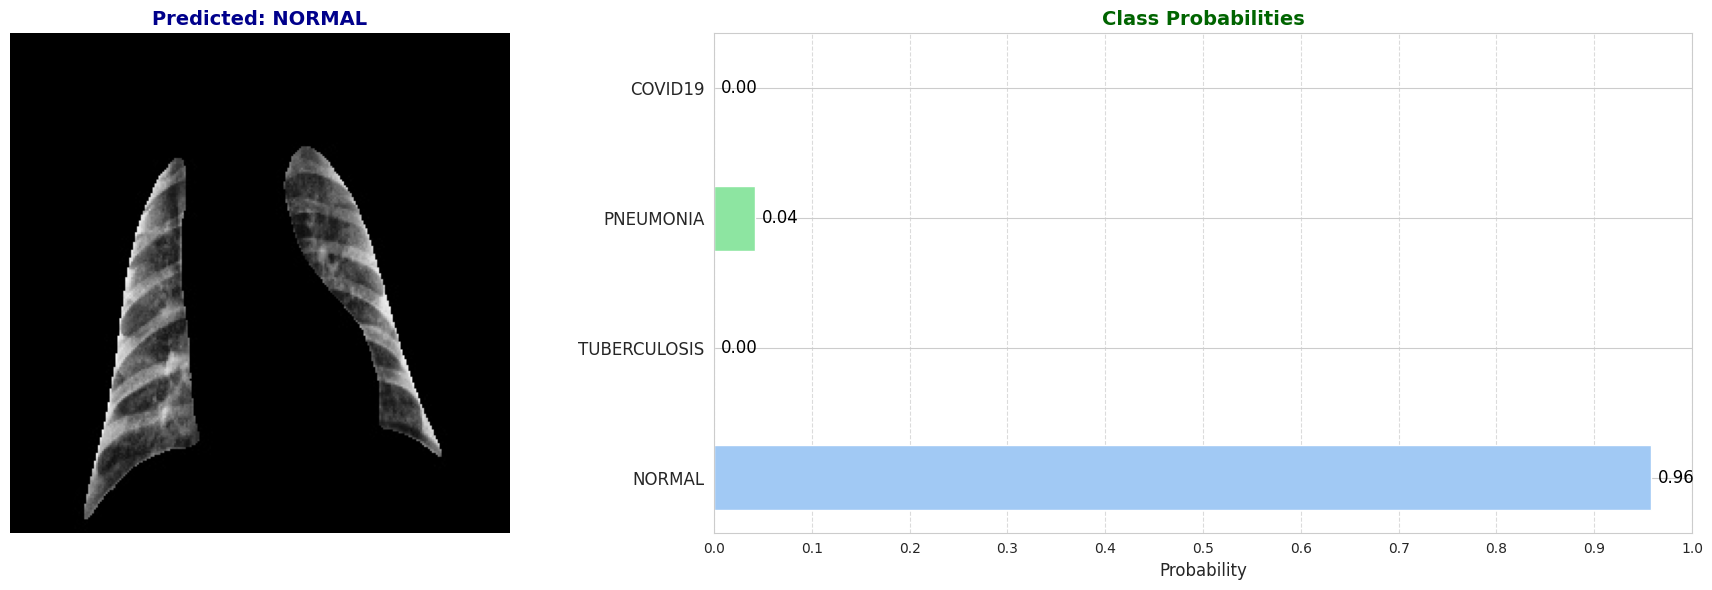

Actual Label   : NORMAL
Predicted Label: NORMAL
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


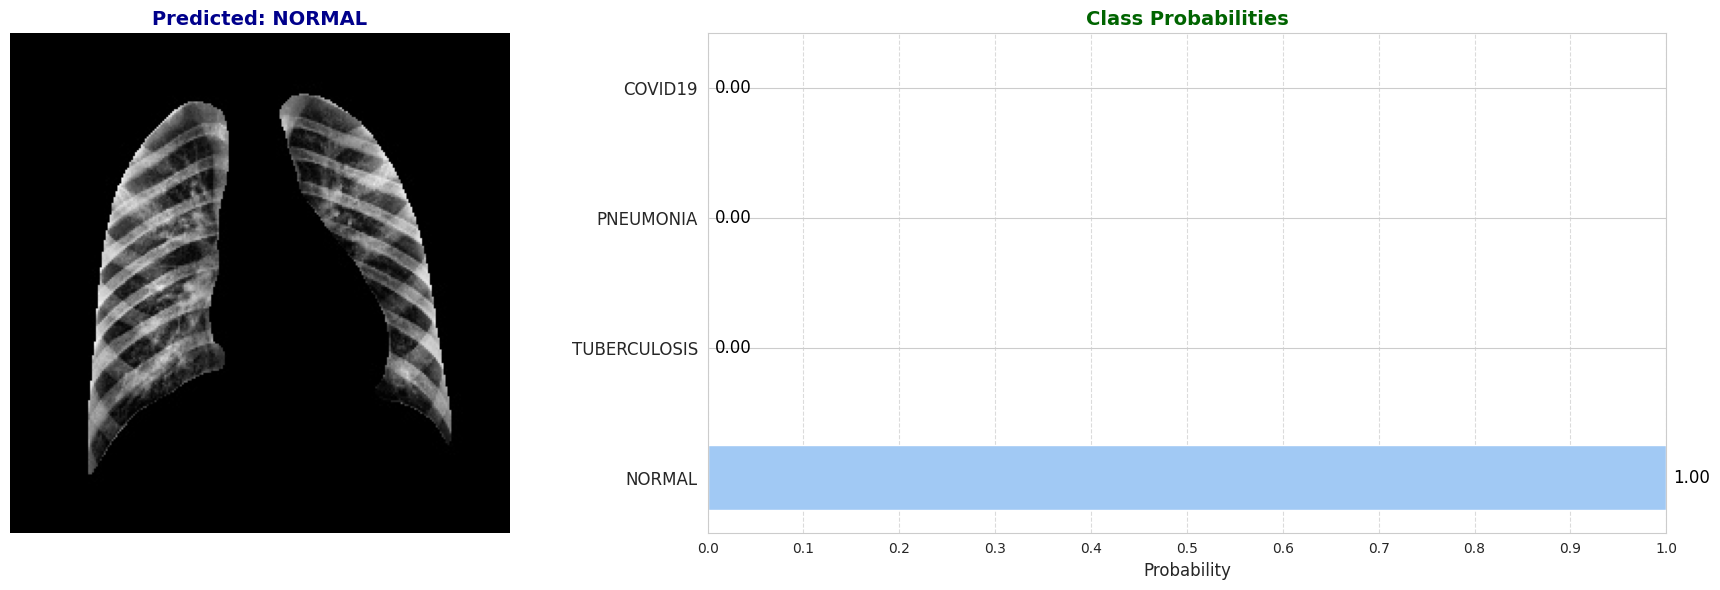

Actual Label   : NORMAL
Predicted Label: NORMAL
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


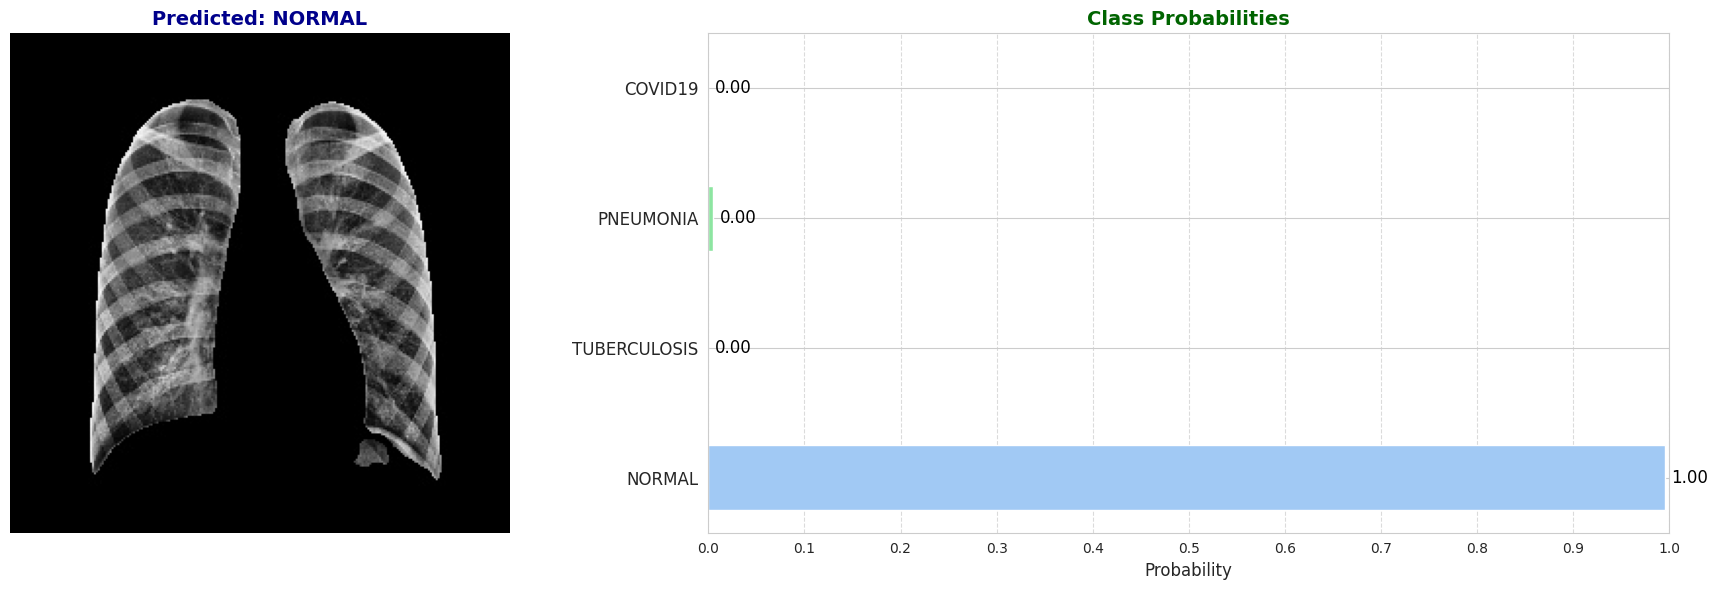

Actual Label   : NORMAL
Predicted Label: NORMAL
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


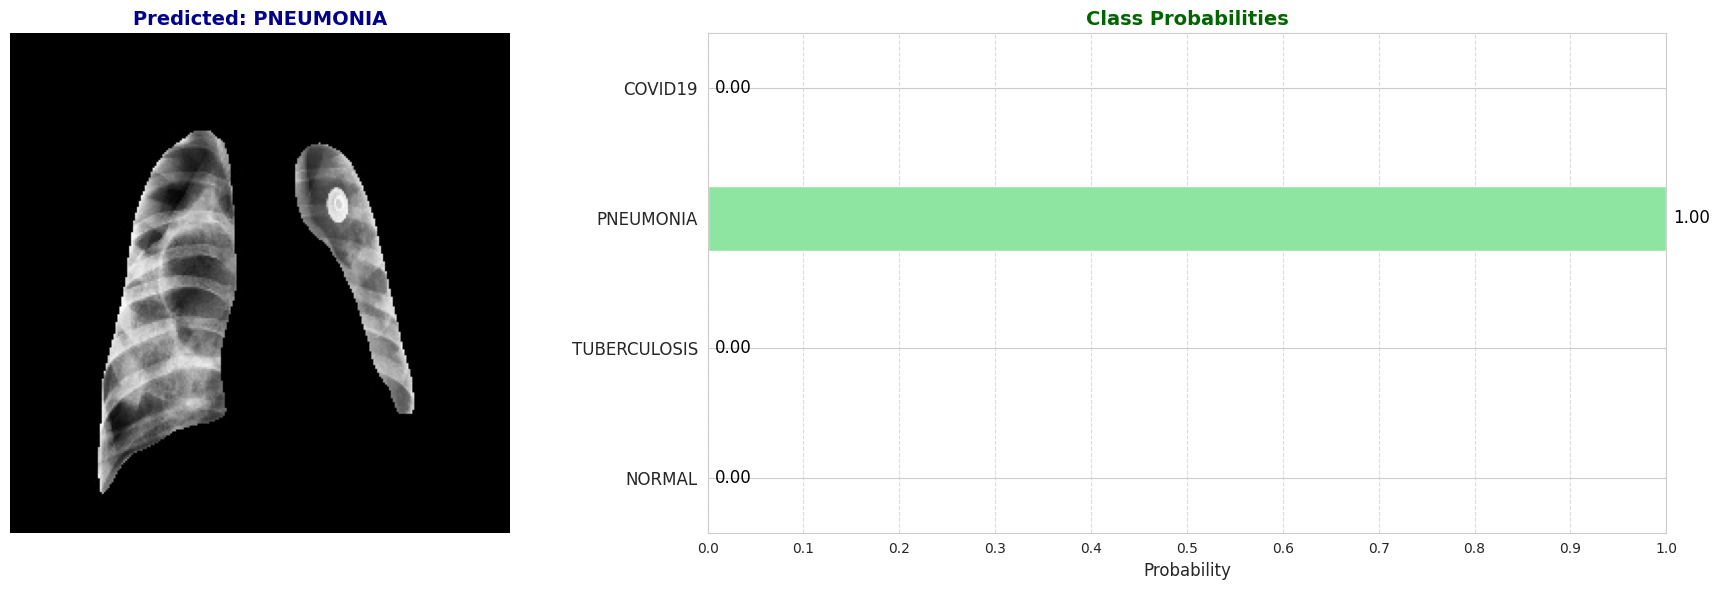

Actual Label   : PNEUMONIA
Predicted Label: PNEUMONIA
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


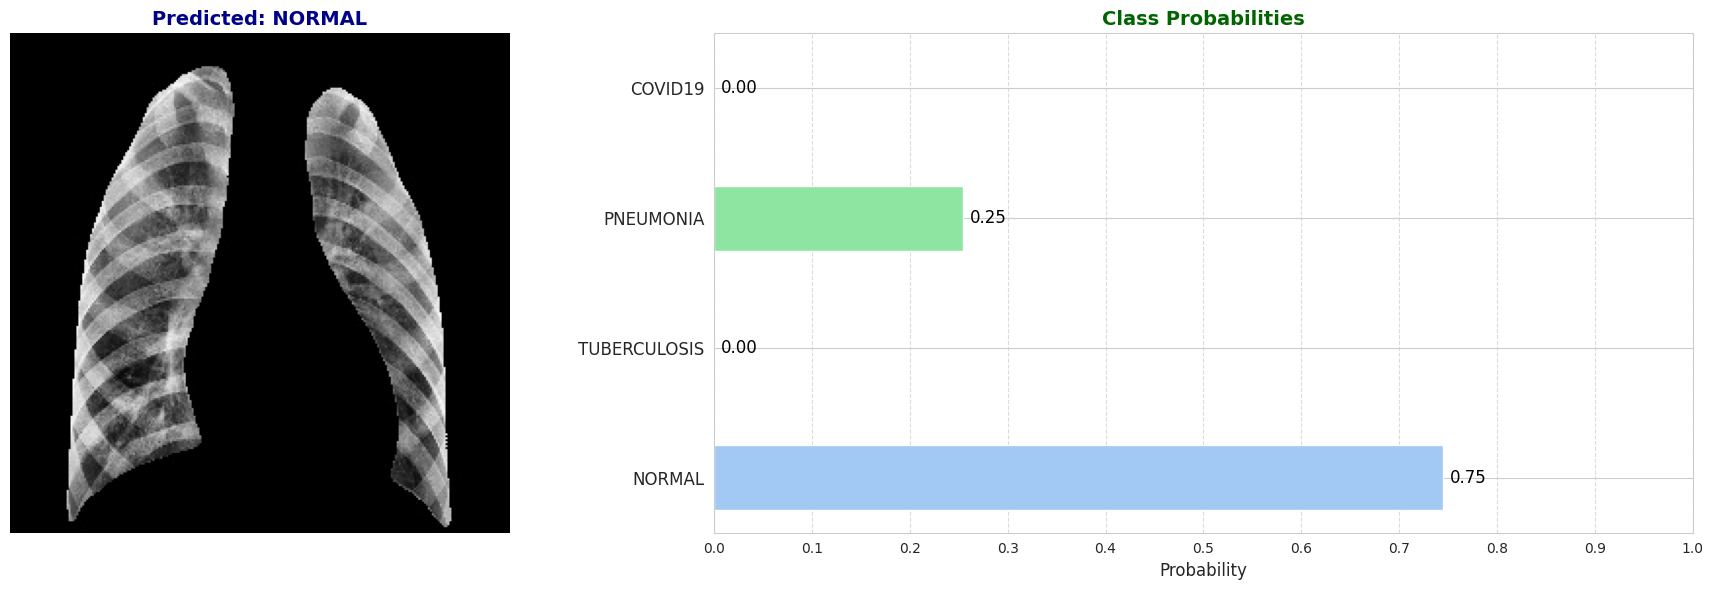

Actual Label   : NORMAL
Predicted Label: NORMAL
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


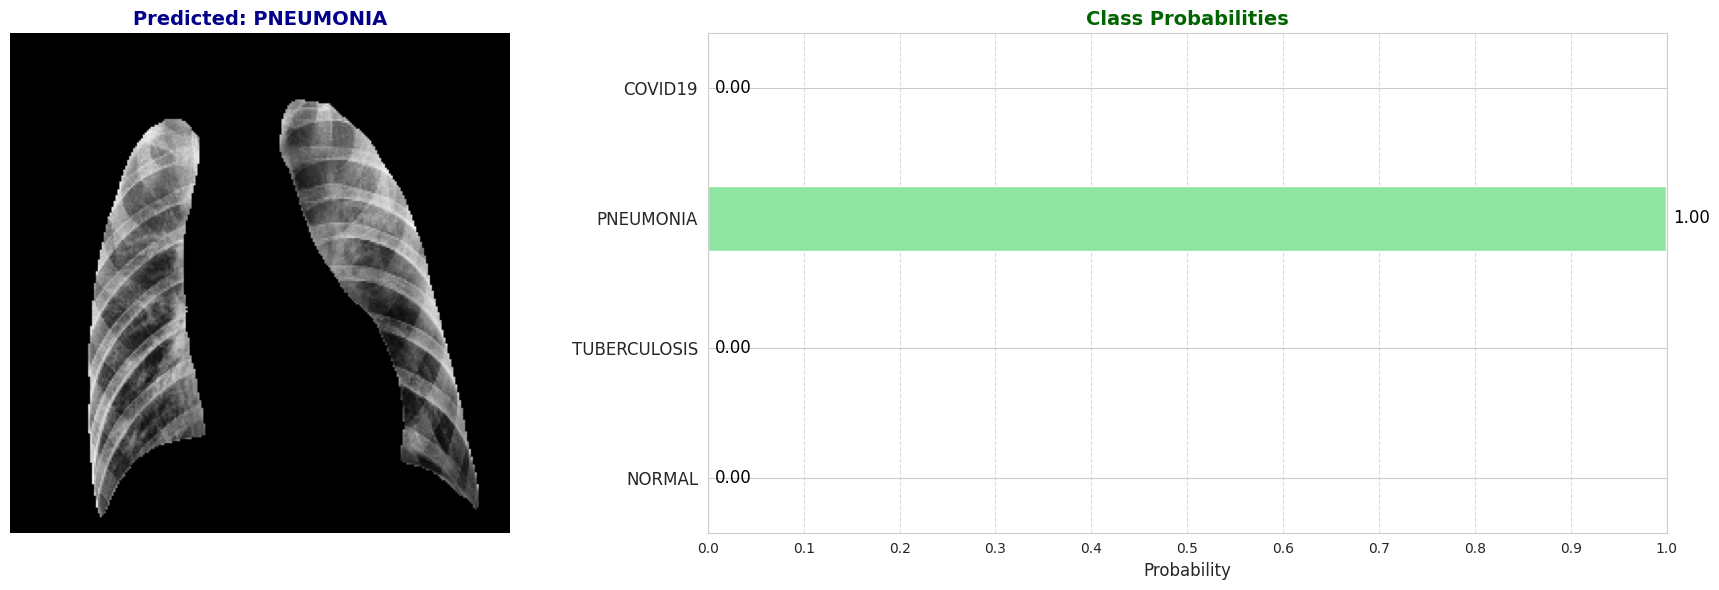

Actual Label   : PNEUMONIA
Predicted Label: PNEUMONIA
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


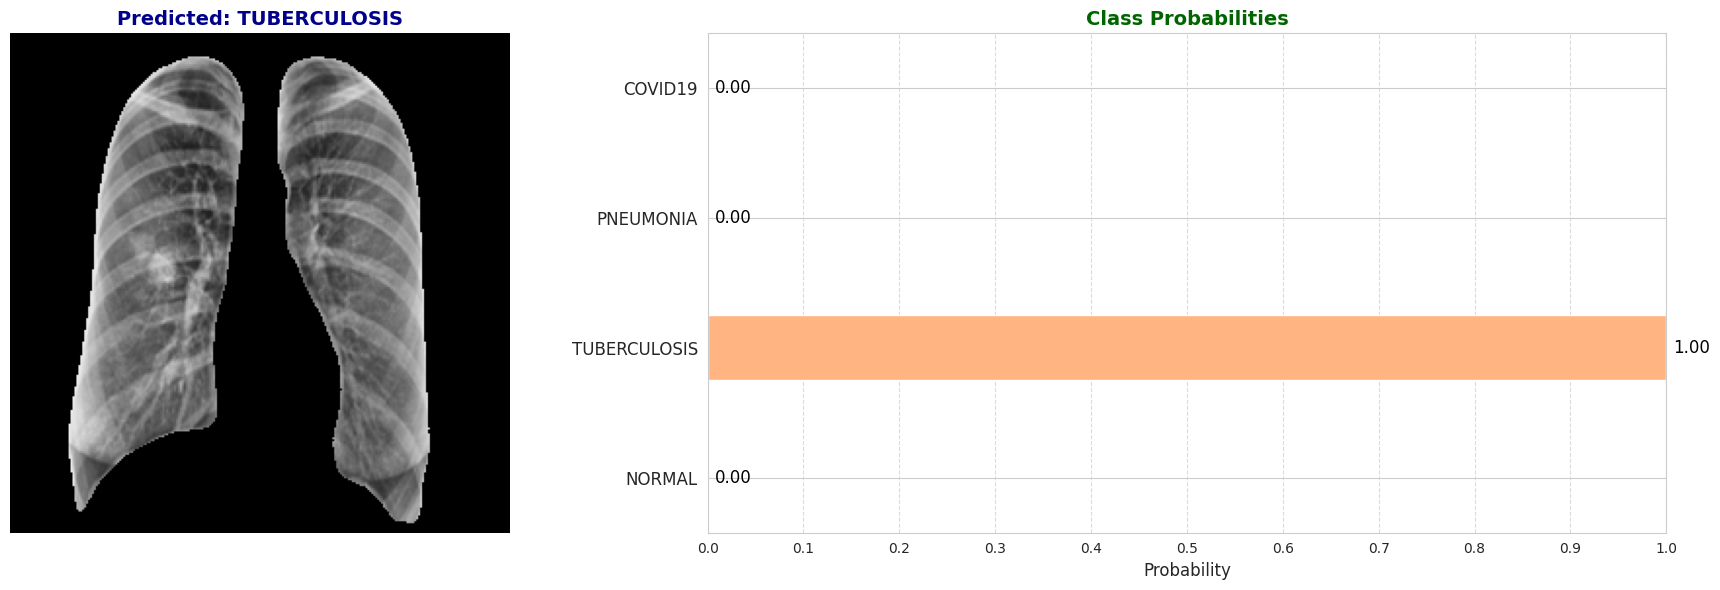

Actual Label   : TUBERCULOSIS
Predicted Label: TUBERCULOSIS
--------------------------------------------------------------------------------




In [27]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img

def predict(image, model):
    model_path = '/kaggle/working/segmentation_model_final.keras'
    labels = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
    image = np.array(image)
    image = image / image.max()  # Normalisasi gambar
    image = image.reshape(-1, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3)  # Ubah bentuk
    probabilities = model.predict(image).reshape(-1)  # Prediksi probabilitas
    pred = labels[np.argmax(probabilities)]  # Kelas dengan probabilitas tertinggi
    return pred, {x: y for x, y in zip(labels, probabilities)}  # Kembalikan prediksi dan probabilitas

# Mengambil 7 indeks acak untuk pengujian
INDICES = random.sample(list(df.index), 7)

for INDEX in INDICES:
    # Muat gambar dan ubah ukurannya
    image = load_img(df.path[INDEX], target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    
    # Dapatkan prediksi dan probabilitas
    pred, probabilities = predict(image, model)

    # Ambil label dan nilai probabilitas
    x = list(probabilities.keys())
    y = list(probabilities.values())

    # Set tampilan untuk visualisasi
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 3]})

    # Plot gambar
    ax[0].imshow(image)
    ax[0].axis('off')  # Matikan sumbu pada gambar
    ax[0].set_title(f'Predicted: {pred}', fontsize=14, color='darkblue', weight='bold')

    # Membuat bar chart untuk probabilitas kelas
    bars = ax[1].barh(x, y, height=0.5, color=sns.color_palette("pastel", len(x)))
    ax[1].bar_label(bars, fmt='%.2f', padding=5, fontsize=12, label_type='edge', color='black')

    ax[1].set_xlim(0, 1)
    ax[1].set_xticks(np.arange(0, 1.1, 0.1))
    ax[1].set_xlabel('Probability', fontsize=12)
    ax[1].set_title('Class Probabilities', fontsize=14, color='darkgreen', weight='bold')
    ax[1].tick_params(axis='y', labelsize=12)
    ax[1].tick_params(axis='x', labelsize=10)
    ax[1].grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Tampilkan hasil pengujian
    print(f"Actual Label   : {df.label[INDEX]}")
    print(f"Predicted Label: {pred}")
    print('-' * 80)
    print('\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


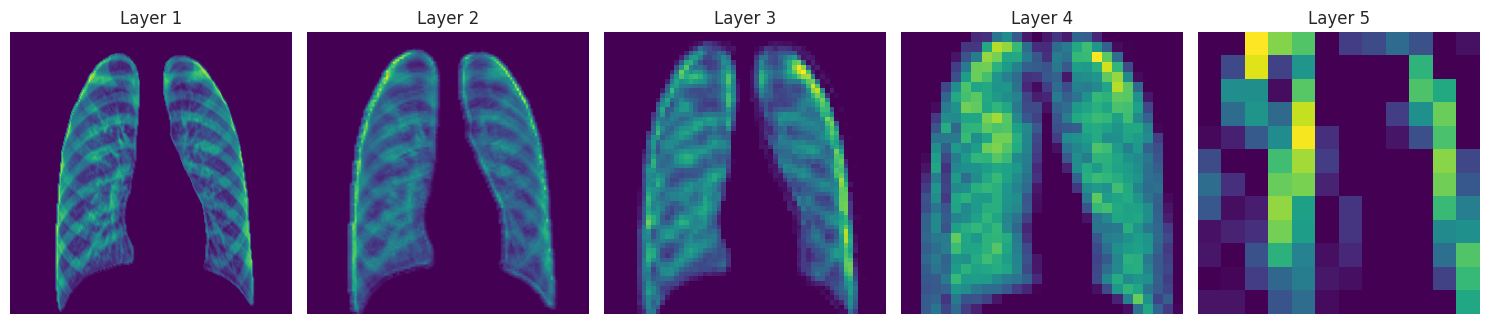

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk memplot feature map terbaik dari tiap layer
def plot_best_feature_maps(model, image_path):
    # Load dan preprocess gambar
    image_input = load_img(image_path, target_size=(256, 256))
    image_input = img_to_array(image_input) / 255.0  # Normalisasi
    image_input = np.expand_dims(image_input, axis=0)  # Tambah batch dimension

    # Pilih layer Conv2D
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    feature_map_model = Model(inputs=model.input, outputs=layer_outputs)

    # Dapatkan feature maps
    feature_maps = feature_map_model.predict(image_input)

    # Plot feature map terbaik dari tiap layer berdasarkan varians tertinggi
    fig, axes = plt.subplots(1, len(feature_maps), figsize=(15, 5))
    for fmap_idx, fmap in enumerate(feature_maps):
        # Hitung varians tiap channel
        variances = np.var(fmap[0], axis=(0, 1))
        best_channel = np.argmax(variances)

        # Plot feature map terbaik secara horizontal
        axes[fmap_idx].imshow(fmap[0, :, :, best_channel], cmap='viridis')
        axes[fmap_idx].set_title(f"Layer {fmap_idx + 1}")
        axes[fmap_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan fungsi
plot_best_feature_maps(model, '/kaggle/input/dataset-klasifikasi-v5/NORMAL/seg_IM-0001-0001.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


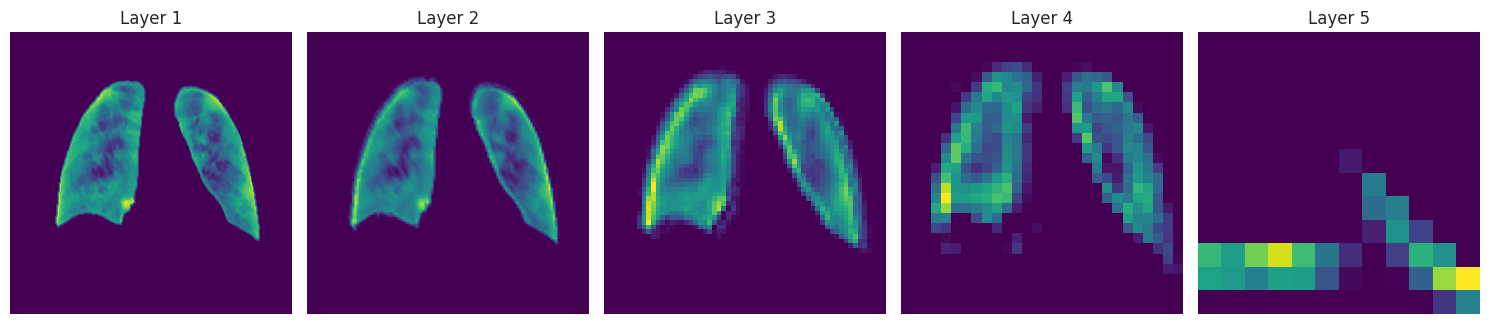

In [29]:
# Contoh pemanggilan fungsi
plot_best_feature_maps(model, '/kaggle/input/dataset-klasifikasi-v5/COVID19/seg_COVID19(1).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


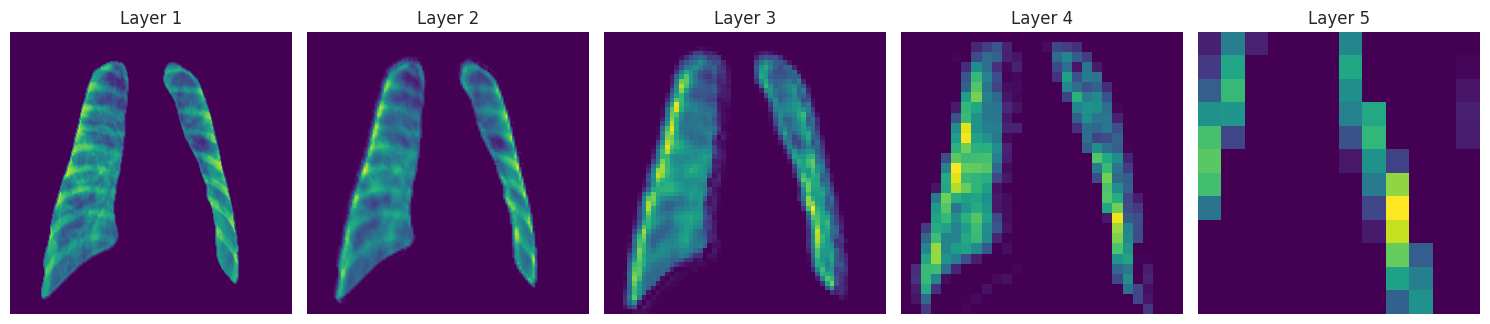

In [30]:

plot_best_feature_maps(model, '/kaggle/input/dataset-klasifikasi-v5/PNEUMONIA/seg_person1000_bacteria_2931.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


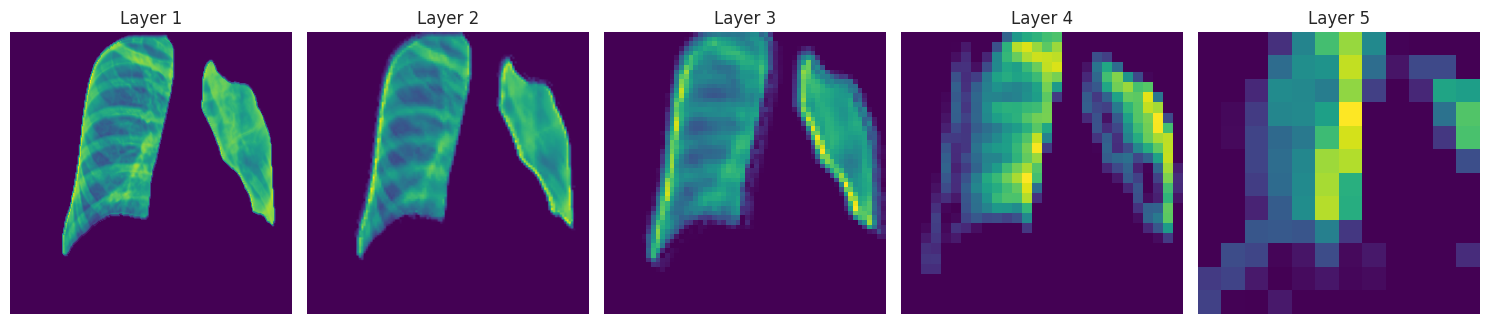

In [31]:
plot_best_feature_maps(model, '/kaggle/input/dataset-klasifikasi-v5/TUBERCULOSIS/seg_Tuberculosis-107.png')